In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지

# import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet

import time
import copy

import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 ROOT 경로 변수
ROOT_PATH = "../chest_xray"

# EfficientNet에 사용 가능하도록 이미지 사이즈 변경

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

../chest_xray


In [3]:
data_transforms = {
    'train' :transforms.Compose([
        transforms.Resize((600,600)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    ]),
    'val' :transforms.Compose([
        transforms.Resize((600,600)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    ]),
    'test' :transforms.Compose([
        transforms.Resize((600,600)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    ])
}

data_dir = '../chest_xray'
image_datasets = {
    x : datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
    for x in ['train','val','test']
}
dataloaders = {
    x : torch.utils.data.DataLoader(image_datasets[x],batch_size=8,shuffle=True,num_workers=4)
    for x in ['train','val','test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

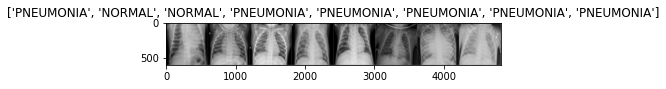

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer ,scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc :{best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far =0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)


In [7]:
print(f"train 에서 음성 데이터 개수 : {np.sum(np.array(image_datasets['train'].imgs)[:,1]=='0')}")
print(f"train 에서 양성 데이터 개수 : {np.sum(np.array(image_datasets['train'].imgs)[:,1]=='1')}")

print(f"val 에서 음성 데이터 개수 : {np.sum(np.array(image_datasets['val'].imgs)[:,1]=='0')}")
print(f"val 에서 양성 데이터 개수 : {np.sum(np.array(image_datasets['val'].imgs)[:,1]=='1')}")

print(f"test 에서 음성 데이터 개수 : {np.sum(np.array(image_datasets['test'].imgs)[:,1]=='0')}")
print(f"test 에서 양성 데이터 개수 : {np.sum(np.array(image_datasets['test'].imgs)[:,1]=='1')}")

train 에서 음성 데이터 개수 : 733
train 에서 양성 데이터 개수 : 3283
val 에서 음성 데이터 개수 : 616
val 에서 양성 데이터 개수 : 600
test 에서 음성 데이터 개수 : 234
test 에서 양성 데이터 개수 : 390


In [8]:
TRAIN_IMG_COUNT= len(image_datasets['train'].imgs)
COUNT_NORMAL= np.sum(np.array(image_datasets['train'].imgs)[:,1]=='0')
COUNT_PNEUMONIA= np.sum(np.array(image_datasets['train'].imgs)[:,1]=='1')

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.74
Weight for class 1: 0.61


In [9]:
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs,2)

In [10]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [11]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [12]:
model = train_model(model,criterion,optimizer,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 